In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch, torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

from cubic_subproblem_solver import *

# Helper functions

In [2]:
def get_principal_vecs(X, k):
    assert k <= X.shape[1]
    sigma, V = torch.linalg.eigh(X.T @ X)
    princ_vecs = V[:,-k:]
    #X_reduced = X @ princ_vecs
    return princ_vecs
   
def load_and_transform_mnist(k):
    mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
    mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
    
    X_train = mnist_trainset.data.reshape(-1,28*28) / 255.
    y_train = mnist_trainset.targets
    X_test = mnist_testset.data.reshape(-1,28*28) / 255.
    y_test = mnist_testset.targets
    
    princ_vecs = get_principal_vecs(X_train, k)
    X_train = X_train @ princ_vecs
    X_test = X_test @ princ_vecs
    
    return X_train, y_train, X_test, y_test

    
class LogisticNet(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)

In [3]:
def evaluate(X, y, model, criterion):
    with torch.no_grad():
        preds = model(X)
        loss = criterion(preds, y)
        preds = torch.argmax(preds, axis=1)
        acc = torch.mean((preds == y).float())
    return loss.item(), acc.item()

def train_SGD(model, optimizer, criterion, batch_size, max_epochs=None, max_time=None, print_every=100):
    assert max_epochs != None or max_time != None
    if max_epochs == None:
        max_epochs = torch.inf
    if max_time == None:
        max_time = torch.inf
    tr_loss, tr_acc = evaluate(X_train, y_train, model, criterion)
    tst_loss, tst_acc = evaluate(X_test, y_test, model, criterion)
    train_loss = [tr_loss]
    test_loss = [tst_loss]
    train_acc = [tr_acc]
    test_acc = [tst_acc]
    training_time = [0]
    print(f'{0: 6,d}: loss = {train_loss[-1]: .5f}, time = {training_time[-1]: .2f} sec')
    
    e = 0
    while (e < max_epochs and training_time[-1] < max_time):
        start_time = time.perf_counter()
        for inputs, targets in zip(X_train.split(batch_size), y_train.split(batch_size)):
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        total_time = time.perf_counter() - start_time
        training_time.append(total_time + training_time[e])
        tr_loss, tr_acc = evaluate(X_train, y_train, model, criterion)
        tst_loss, tst_acc = evaluate(X_test, y_test, model, criterion)
        train_loss.append(tr_loss)
        test_loss.append(tst_loss)
        train_acc.append(tr_acc)
        test_acc.append(tst_acc)
        if (e+1) % print_every == 0:
            print(f'{e+1: 6,d}: loss = {train_loss[-1]: .5f}, time = {training_time[-1]: .2f} sec')
        e += 1
    
    # Converting to nd.array and removing the rasults after max_time 
    train_loss = np.array(train_loss[:-1])
    test_loss = np.array(test_loss[:-1])
    train_acc = np.array(train_acc[:-1])
    test_acc = np.array(test_acc[:-1])
    training_time = np.array(training_time[:-1])
    
    return train_loss, test_loss, train_acc, test_acc, training_time

In [4]:
def loss(X, y, model, criterion):
    pred = model(X)
    return criterion(pred, y).item()

def gradint(X, y, model, criterion):
    preds = model(X)
    loss = criterion(preds, y)
    gradients = torch.autograd.grad(loss, model.parameters())
    grad = torch.cat([g.flatten() for g in gradients], dim=0)
    return grad

def hessian(X, y, model, criterion):
    
    def calculate_loss(*params):
        preds = X @ params[0].T + params[1]
        return criterion(preds, y)
    
    params = tuple([p.data for p in model.parameters()])
    hessians = torch.autograd.functional.hessian(calculate_loss, params)
    hess_1 = torch.cat([hessians[0][0].view(200,200), hessians[0][1].view(200,10)], dim=1)
    hess_2 = torch.cat([hessians[1][0].view(10,200), hessians[1][1]], dim=1)
    hess = torch.cat([hess_1, hess_2], dim=0)
    return hess

def quadratic_form(loss, grad, hess, M, h):
    return loss + torch.dot(grad,h) + 0.5 * torch.dot(hess @ h, h) + M/6 * torch.linalg.norm(h,2)**3

def update_model_params(model, h):
    t = list(torch.split(h, [200, 10]))
    t[0] = t[0].view(10,20)
    for i, p in enumerate(model.parameters()):
        p.data += t[i]

def get_next_model(model, h):
    model_next = LogisticNet(20,10)
    for p, p_next in zip(model.parameters(), model_next.parameters()):
        p_next.data = p.data.clone()
    update_model_params(model_next, h)
    return model_next

In [5]:
def train_Cubic_Newton(X_train, y_train, model, criterion, M_0, max_time):
    M = M_0
    tr_loss, tr_acc = evaluate(X_train, y_train, model, criterion)
    tst_loss, tst_acc = evaluate(X_test, y_test, model, criterion)
    train_loss = [tr_loss]
    test_loss = [tst_loss]
    train_acc = [tr_acc]
    test_acc = [tst_acc]
    training_time = [0]
    print(f'{0: 4,d}: loss = {train_loss[-1]: .5f}, M = {M}, time = {training_time[-1]: .2f} sec')

    i = 0
    while (training_time[-1] < max_time):
        start_time = time.perf_counter()
        loss_current = loss(X_train, y_train, model, criterion)
        grad = gradint(X_train, y_train, model, criterion)
        hess = hessian(X_train, y_train, model, criterion)
        h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), M))
        model_next = get_next_model(model, h)

        while (loss(X_train, y_train, model_next, criterion) > quadratic_form(loss_current,grad,hess,M,h)):
            M *= 2
            h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), M))
            model_next = get_next_model(model, h)

        update_model_params(model, h)
        M /= 2
        total_time = time.perf_counter() - start_time
        training_time.append(total_time + training_time[i])
        tr_loss, tr_acc = evaluate(X_train, y_train, model, criterion)
        tst_loss, tst_acc = evaluate(X_test, y_test, model, criterion)
        train_loss.append(tr_loss)
        test_loss.append(tst_loss)
        train_acc.append(tr_acc)
        test_acc.append(tst_acc)
        print(f'{i+1: 4,d}: loss = {train_loss[-1]: .5f}, M = {M}, time = {training_time[-1]: .2f} sec')
        i += 1
    
    # Converting to nd.array and removing the rasults after max_time 
    train_loss = np.array(train_loss[:-1])
    test_loss = np.array(test_loss[:-1])
    train_acc = np.array(train_acc[:-1])
    test_acc = np.array(test_acc[:-1])
    training_time = np.array(training_time[:-1])
    
    return train_loss, test_loss, train_acc, test_acc, training_time

# Hyperparameters tuning for GD and SGD

In [67]:
def hyperparams_tuning(lrs, momentums, epochs, batch_size):
    params = []
    res = []
    for lr in lrs:
        for momentum in momentums:
            model = LogisticNet(20,10)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            criterion = nn.CrossEntropyLoss()
            train_loss, test_loss, train_acc, test_acc, training_time = train_SGD(
                model, optimizer, criterion, batch_size, max_epochs=epochs)
            params.append({'lr': lr, 'mom': momentum})
            res.append(test_loss)
    return params, res

### SGD

In [93]:
batch_size = 128
epochs = 400

lrs = [3e-2, 1e-2]
momentums = [0.0]

params, res = hyperparams_tuning(lrs, momentums, epochs, batch_size)

     0: loss =  2.63402, time =  0.00 sec
   100: loss =  0.41633, time =  17.43 sec
   200: loss =  0.41613, time =  40.77 sec
   300: loss =  0.41610, time =  61.72 sec
   400: loss =  0.41610, time =  86.39 sec
     0: loss =  2.72604, time =  0.00 sec
   100: loss =  0.41838, time =  21.72 sec
   200: loss =  0.41599, time =  44.78 sec
   300: loss =  0.41562, time =  68.69 sec
   400: loss =  0.41552, time =  89.65 sec


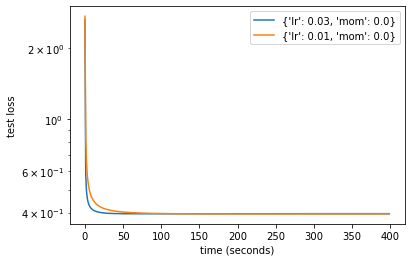

In [94]:
iters = np.arange(epochs)
for p, tst_loss in zip(params, res):
    if (p["mom"] == 0.0):
        plt.plot(iters, tst_loss, label=p)
        plt.xlabel('time (seconds)')
        plt.ylabel('test loss')
        plt.yscale('log')
        plt.legend()

In [95]:
for p, tst_loss in zip(params, res):
    if p["mom"] == 0.0:
        print(f'lr: {p["lr"]: .4f}, mom: {[p["mom"]]} test loss = {tst_loss[-1]: .5f}')

lr:  0.0300, mom: [0.0] test loss =  0.39606
lr:  0.0100, mom: [0.0] test loss =  0.39521


best lr = 0.01

### GD

In [90]:
batch_size = 60000 # whole dataset
epochs = 3000

lrs = lrs = [1e0, 3e-1]
momentums = [0.0]

params, res = hyperparams_tuning(lrs, momentums, epochs, batch_size)

     0: loss =  2.90844, time =  0.00 sec
   100: loss =  0.44628, time =  1.66 sec
   200: loss =  0.42747, time =  3.55 sec
   300: loss =  0.42187, time =  5.35 sec
   400: loss =  0.41923, time =  7.18 sec
   500: loss =  0.41782, time =  9.15 sec
   600: loss =  0.41699, time =  12.73 sec
   700: loss =  0.41649, time =  15.21 sec
   800: loss =  0.41617, time =  17.43 sec
   900: loss =  0.41596, time =  21.03 sec
 1,000: loss =  0.41582, time =  22.82 sec
 1,100: loss =  0.41572, time =  25.61 sec
 1,200: loss =  0.41564, time =  28.59 sec
 1,300: loss =  0.41559, time =  30.24 sec
 1,400: loss =  0.41555, time =  32.36 sec
 1,500: loss =  0.41552, time =  35.59 sec
 1,600: loss =  0.41550, time =  37.68 sec
 1,700: loss =  0.41548, time =  39.38 sec
 1,800: loss =  0.41546, time =  42.14 sec
 1,900: loss =  0.41545, time =  45.04 sec
 2,000: loss =  0.41544, time =  46.65 sec
 2,100: loss =  0.41543, time =  49.29 sec
 2,200: loss =  0.41542, time =  52.51 sec
 2,300: loss =  0

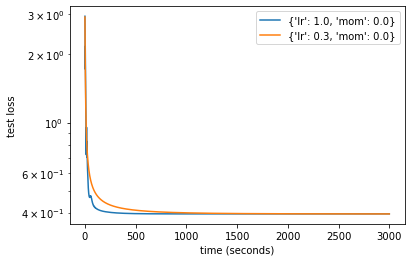

In [91]:
iters = np.arange(epochs)
for p, tst_loss in zip(params, res):
    plt.plot(iters, tst_loss, label=p)
    plt.xlabel('time (seconds)')
    plt.ylabel('test loss')
    plt.yscale('log')
    plt.legend()

In [92]:
for p, tst_loss in zip(params, res):
    print(f'lr: {p["lr"]: .4f}, mom: {[p["mom"]]} test loss = {tst_loss[-1]: .5f}')

lr:  1.0000, mom: [0.0] test loss =  0.39534
lr:  0.3000, mom: [0.0] test loss =  0.39501


best lr = 0.3

# Experiments

In [6]:
k = 20

X_train, y_train, X_test, y_test = load_and_transform_mnist(k)

In [17]:
train_loss, test_loss, train_acc, test_acc, training_time = {}, {}, {}, {}, {}
max_time = 100 # (in seconds)
criterion = nn.CrossEntropyLoss()

# SGD
model = LogisticNet(20,10)
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
batch_size = 128

print('TRAIN SGD')
train_loss["SGD"], test_loss["SGD"], train_acc["SGD"], test_acc["SGD"], training_time["SGD"] = train_SGD(
    model, optimizer, criterion, batch_size, max_time=max_time, print_every=100)
print()

# GD
model = LogisticNet(20,10)
lr = 3e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
batch_size = 60000 # whole dataset

print('TRAIN GD')
train_loss["GD"], test_loss["GD"], train_acc["GD"], test_acc["GD"], training_time["GD"] = train_SGD(
    model, optimizer, criterion, batch_size, max_time=max_time, print_every=100)
print()

model = LogisticNet(20,10)
M_0 = 0.01

print('TRAIN CUBIC_NEWTON')
train_loss["Cubic Newton"], test_loss["Cubic Newton"], train_acc["Cubic Newton"], \
test_acc["Cubic Newton"], training_time["Cubic Newton"] = train_Cubic_Newton(
    X_train, y_train, model, criterion, M_0, max_time)
print()

TRAIN SGD
     0: loss =  2.79479, time =  0.00 sec
   100: loss =  0.41853, time =  16.84 sec
   200: loss =  0.41607, time =  33.78 sec
   300: loss =  0.41567, time =  52.39 sec
   400: loss =  0.41555, time =  71.86 sec
   500: loss =  0.41549, time =  92.82 sec

TRAIN GD
     0: loss =  2.77011, time =  0.00 sec
   100: loss =  0.51543, time =  2.08 sec
   200: loss =  0.46736, time =  4.09 sec
   300: loss =  0.44951, time =  7.44 sec
   400: loss =  0.44008, time =  9.23 sec
   500: loss =  0.43424, time =  11.30 sec
   600: loss =  0.43026, time =  14.35 sec
   700: loss =  0.42740, time =  16.48 sec
   800: loss =  0.42526, time =  18.24 sec
   900: loss =  0.42360, time =  20.99 sec
 1,000: loss =  0.42229, time =  23.66 sec
 1,100: loss =  0.42125, time =  25.45 sec
 1,200: loss =  0.42039, time =  28.21 sec
 1,300: loss =  0.41969, time =  30.85 sec
 1,400: loss =  0.41911, time =  32.63 sec
 1,500: loss =  0.41863, time =  35.10 sec
 1,600: loss =  0.41822, time =  38.15 s

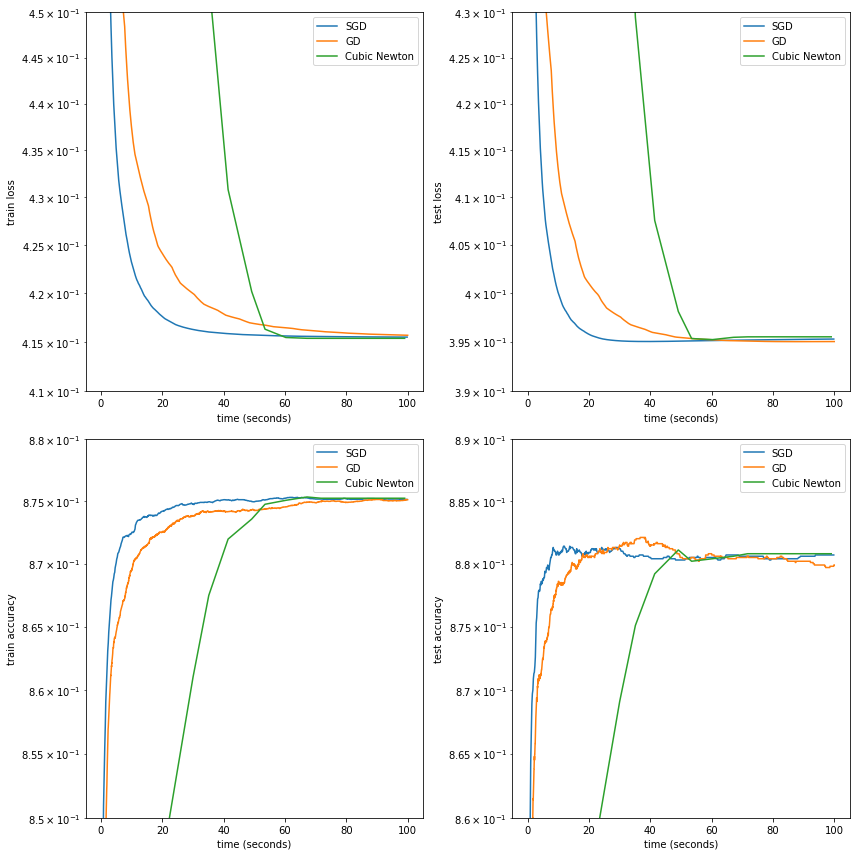

In [29]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0,0].plot(training_time["SGD"], train_loss["SGD"], label='SGD')
ax[0,0].plot(training_time["GD"], train_loss["GD"], label='GD')
ax[0,0].plot(training_time["Cubic Newton"], train_loss["Cubic Newton"], label='Cubic Newton')
ax[0,0].set_xlabel('time (seconds)')
ax[0,0].set_ylabel('train loss')
ax[0,0].set_yscale('log')
ax[0,0].set_ylim([0.41, 0.45])
ax[0,0].legend()

ax[0,1].plot(training_time["SGD"], test_loss["SGD"], label='SGD')
ax[0,1].plot(training_time["GD"], test_loss["GD"], label='GD')
ax[0,1].plot(training_time["Cubic Newton"], test_loss["Cubic Newton"], label='Cubic Newton')
ax[0,1].set_xlabel('time (seconds)')
ax[0,1].set_ylabel('test loss')
ax[0,1].set_ylim([0.39, 0.43])
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(training_time["SGD"], train_acc["SGD"], label='SGD')
ax[1,0].plot(training_time["GD"], train_acc["GD"], label='GD')
ax[1,0].plot(training_time["Cubic Newton"], train_acc["Cubic Newton"], label='Cubic Newton')
ax[1,0].set_xlabel('time (seconds)')
ax[1,0].set_ylabel('train accuracy')
ax[1,0].set_yscale('log')
ax[1,0].set_ylim([0.85, 0.88])
ax[1,0].legend()

ax[1,1].plot(training_time["SGD"], test_acc["SGD"], label='SGD')
ax[1,1].plot(training_time["GD"], test_acc["GD"], label='GD')
ax[1,1].plot(training_time["Cubic Newton"], test_acc["Cubic Newton"], label='Cubic Newton')
ax[1,1].set_xlabel('time (seconds)')
ax[1,1].set_ylabel('test accuracy')
ax[1,1].set_yscale('log')
ax[1,1].set_ylim([0.86, 0.89])
ax[1,1].legend()

fig.tight_layout()
plt.show()

In [42]:
print('Final TRAIN LOSS')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {train_loss[method][-1]: .5f}')
print()

print('Final TEST LOSS')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {test_loss[method][-1]: .5f}')
print()

print('Final TRAIN ACCURACY')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {train_acc[method][-1]: .5f}')
print()

print('Final TEST ACCURACY')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {test_acc[method][-1]: .5f}')
print()

Final TRAIN LOSS
         SGD:  0.41548
          GD:  0.41567
Cubic Newton:  0.41536

Final TEST LOSS
         SGD:  0.39528
          GD:  0.39502
Cubic Newton:  0.39550

Final TRAIN ACCURACY
         SGD:  0.87513
          GD:  0.87512
Cubic Newton:  0.87523

Final TEST ACCURACY
         SGD:  0.88070
          GD:  0.87990
Cubic Newton:  0.88080

